In [1]:
import argparse
import torch
import dataloader
from models import main_models
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [2]:
# parser=argparse.ArgumentParser()
# parser.add_argument('--n_epoches_1',type=int,default=10)
# parser.add_argument('--n_epoches_2',type=int,default=100)
# parser.add_argument('--n_epoches_3',type=int,default=100)
# parser.add_argument('--n_target_samples',type=int,default=7)
# parser.add_argument('--batch_size',type=int,default=64)

# opt=vars(parser.parse_args())
opt = {}
opt['n_epoches_1'] = 10
opt['n_epoches_2'] = 100
opt['n_epoches_3'] = 100
opt['n_target_samples'] = 7
opt['batch_size'] = 64


use_cuda=True if torch.cuda.is_available() else False
device=torch.device('cuda:0') if use_cuda else torch.device('cpu')
torch.manual_seed(1)
if use_cuda:
    torch.cuda.manual_seed(1)


#--------------pretrain g and h for step 1---------------------------------
train_dataloader=dataloader.mnist_dataloader(batch_size=opt['batch_size'],train=True)
test_dataloader=dataloader.mnist_dataloader(batch_size=opt['batch_size'],train=False)

classifier=main_models.Classifier()
encoder=main_models.Encoder()
discriminator=main_models.DCD(input_features=128)

classifier.to(device)
encoder.to(device)
discriminator.to(device)
loss_fn=torch.nn.CrossEntropyLoss()

optimizer=torch.optim.Adam(list(encoder.parameters())+list(classifier.parameters()))

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


In [3]:

for epoch in range(opt['n_epoches_1']):
    for data,labels in train_dataloader:
        data=data.to(device)
        labels=labels.to(device)

        optimizer.zero_grad()

        y_pred=classifier(encoder(data))

        loss=loss_fn(y_pred,labels)
        loss.backward()

        optimizer.step()

    acc=0
    for data,labels in test_dataloader:
        data=data.to(device)
        labels=labels.to(device)
        y_test_pred=classifier(encoder(data))
        acc+=(torch.max(y_test_pred,1)[1]==labels).float().mean().item()

    accuracy=round(acc / float(len(test_dataloader)), 3)

    print("step1----Epoch %d/%d  accuracy: %.3f "%(epoch+1,opt['n_epoches_1'],accuracy))
#-------------------------------------------------------------------

step1----Epoch 1/10  accuracy: 0.969 


KeyboardInterrupt: 

In [ ]:
import sys
feature_vector = []
labels_vector = []
for data,labels in test_dataloader:
        data=data.to(device)
        labels=labels.to(device)
        y_test_pred=classifier(encoder(data))
        for i in range(len(labels)):
            feature_vector.append(y_test_pred[i].cpu().detach().tolist())
            labels_vector.append(labels[i].cpu().detach().tolist())
#         print (y_test_pred.shape)
#         feature_vector += y_test_pred.cpu().detach().numpy()
#         labels_vector += labels.cpu().detach().numpy()
        
#         sys.exit()
print (np.array(labels_vector).shape)
print (np.array(feature_vector).shape)

In [41]:
# We import sklearn.
import sklearn
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import scale

# We'll hack a bit with the t-SNE code in sklearn 0.15.2.
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.manifold.t_sne import (_joint_probabilities,
                                    _kl_divergence)

# Random state.
RS = 20150101
no = 200
new_feature_stack = np.array(feature_vector[:no] + feature_vector[-no:])
    
print (len(new_feature_stack))
digits_proj = TSNE(random_state=RS).fit_transform(new_feature_stack)

400


In [42]:
new_labels_vector = np.array(labels_vector[:no] + labels_vector[-no:])
print (new_feature_stack.shape)
print (new_labels_vector.shape)

(400, 10)
(400,)


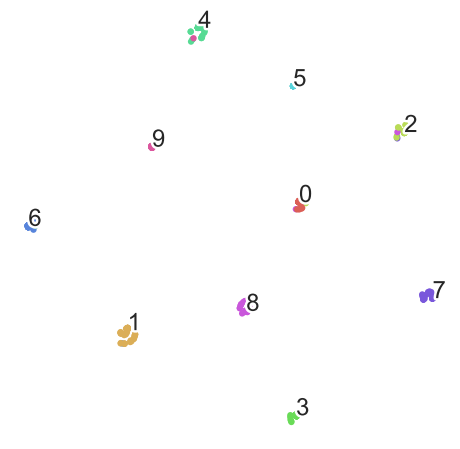

In [43]:
# We import seaborn to make nice plots.
import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
# We'll use matplotlib for graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib
def scatter(x, colors):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts
scatter(digits_proj, new_labels_vector)
plt.show()

In [11]:
X_s,Y_s=dataloader.sample_data()
X_t,Y_t=dataloader.create_target_samples(opt['n_target_samples'])

#-----------------train DCD for step 2--------------------------------

optimizer_D=torch.optim.Adam(discriminator.parameters(),lr=0.001)


for epoch in range(opt['n_epoches_2']):
    # data
    groups,aa = dataloader.sample_groups(X_s,Y_s,X_t,Y_t,seed=epoch)

    n_iters = 4 * len(groups[1])
    index_list = torch.randperm(n_iters)
    mini_batch_size=40 #use mini_batch train can be more stable


    loss_mean=[]

    X1=[];X2=[];ground_truths=[]
    for index in range(n_iters):

        ground_truth=index_list[index]//len(groups[1])

        x1,x2=groups[ground_truth][index_list[index]-len(groups[1])*ground_truth]
        X1.append(x1)
        X2.append(x2)
        ground_truths.append(ground_truth)

        #select data for a mini-batch to train
        if (index+1)%mini_batch_size==0:
            X1=torch.stack(X1)
            X2=torch.stack(X2)
            ground_truths=torch.LongTensor(ground_truths)
            X1=X1.to(device)
            X2=X2.to(device)
            ground_truths=ground_truths.to(device)

            optimizer_D.zero_grad()
            X_cat=torch.cat([encoder(X1),encoder(X2)],1)
            y_pred=discriminator(X_cat.detach())
            loss=loss_fn(y_pred,ground_truths)
            loss.backward()
            optimizer_D.step()
            loss_mean.append(loss.item())
            X1 = []
            X2 = []
            ground_truths = []

    print("step2----Epoch %d/%d loss:%.3f"%(epoch+1,opt['n_epoches_2'],np.mean(loss_mean)))

#----------------------------------------------------------------------

Using downloaded and verified file: ./data/SVHN\train_32x32.mat
Sampling groups
step2----Epoch 1/100 loss:1.370
Sampling groups
step2----Epoch 2/100 loss:1.288
Sampling groups
step2----Epoch 3/100 loss:1.232
Sampling groups
step2----Epoch 4/100 loss:1.181
Sampling groups
step2----Epoch 5/100 loss:1.141
Sampling groups
step2----Epoch 6/100 loss:1.098
Sampling groups
step2----Epoch 7/100 loss:1.089
Sampling groups
step2----Epoch 8/100 loss:1.050
Sampling groups
step2----Epoch 9/100 loss:1.045
Sampling groups
step2----Epoch 10/100 loss:1.045
Sampling groups
step2----Epoch 11/100 loss:1.040
Sampling groups
step2----Epoch 12/100 loss:1.023
Sampling groups
step2----Epoch 13/100 loss:1.031
Sampling groups
step2----Epoch 14/100 loss:1.029
Sampling groups
step2----Epoch 15/100 loss:1.034
Sampling groups
step2----Epoch 16/100 loss:1.002
Sampling groups
step2----Epoch 17/100 loss:1.012
Sampling groups
step2----Epoch 18/100 loss:1.003
Sampling groups
step2----Epoch 19/100 loss:1.029
Sampling group

In [5]:
#-------------------training for step 3-------------------
optimizer_g_h=torch.optim.Adam(list(encoder.parameters())+list(classifier.parameters()),lr=0.001)
optimizer_d=torch.optim.Adam(discriminator.parameters(),lr=0.001)


test_dataloader=dataloader.svhn_dataloader(train=False,batch_size=opt['batch_size'])


for epoch in range(opt['n_epoches_3']):
    #---training g and h , DCD is frozen

    groups, groups_y = dataloader.sample_groups(X_s,Y_s,X_t,Y_t,seed=opt['n_epoches_2']+epoch)
    G1, G2, G3, G4 = groups
    Y1, Y2, Y3, Y4 = groups_y
    groups_2 = [G2, G4]
    groups_y_2 = [Y2, Y4]

    n_iters = 2 * len(G2)
    index_list = torch.randperm(n_iters)

    n_iters_dcd = 4 * len(G2)
    index_list_dcd = torch.randperm(n_iters_dcd)

    mini_batch_size_g_h = 20 #data only contains G2 and G4 ,so decrease mini_batch
    mini_batch_size_dcd= 40 #data contains G1,G2,G3,G4 so use 40 as mini_batch
    X1 = []
    X2 = []
    ground_truths_y1 = []
    ground_truths_y2 = []
    dcd_labels=[]
    for index in range(n_iters):


        ground_truth=index_list[index]//len(G2)
        x1, x2 = groups_2[ground_truth][index_list[index] - len(G2) * ground_truth]
        y1, y2 = groups_y_2[ground_truth][index_list[index] - len(G2) * ground_truth]
        # y1=torch.LongTensor([y1.item()])
        # y2=torch.LongTensor([y2.item()])
        dcd_label=0 if ground_truth==0 else 2
        X1.append(x1)
        X2.append(x2)
        ground_truths_y1.append(y1)
        ground_truths_y2.append(y2)
        dcd_labels.append(dcd_label)

        if (index+1)%mini_batch_size_g_h==0:

            X1=torch.stack(X1)
            X2=torch.stack(X2)
            ground_truths_y1=torch.LongTensor(ground_truths_y1)
            ground_truths_y2 = torch.LongTensor(ground_truths_y2)
            dcd_labels=torch.LongTensor(dcd_labels)
            X1=X1.to(device)
            X2=X2.to(device)
            ground_truths_y1=ground_truths_y1.to(device)
            ground_truths_y2 = ground_truths_y2.to(device)
            dcd_labels=dcd_labels.to(device)

            optimizer_g_h.zero_grad()

            encoder_X1=encoder(X1)
            encoder_X2=encoder(X2)

            X_cat=torch.cat([encoder_X1,encoder_X2],1)
            y_pred_X1=classifier(encoder_X1)
            y_pred_X2=classifier(encoder_X2)
            y_pred_dcd=discriminator(X_cat)

            loss_X1=loss_fn(y_pred_X1,ground_truths_y1)
            loss_X2=loss_fn(y_pred_X2,ground_truths_y2)
            loss_dcd=loss_fn(y_pred_dcd,dcd_labels)

            loss_sum = loss_X1 + loss_X2 + 0.2 * loss_dcd

            loss_sum.backward()
            optimizer_g_h.step()

            X1 = []
            X2 = []
            ground_truths_y1 = []
            ground_truths_y2 = []
            dcd_labels = []

Using downloaded and verified file: ./data/SVHN\test_32x32.mat
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling groups
Sampling 

In [6]:
    #----training dcd ,g and h frozen
    X1 = []
    X2 = []
    ground_truths = []
    for index in range(n_iters_dcd):

        ground_truth=index_list_dcd[index]//len(groups[1])

        x1, x2 = groups[ground_truth][index_list_dcd[index] - len(groups[1]) * ground_truth]
        X1.append(x1)
        X2.append(x2)
        ground_truths.append(ground_truth)

        if (index + 1) % mini_batch_size_dcd == 0:
            X1 = torch.stack(X1)
            X2 = torch.stack(X2)
            ground_truths = torch.LongTensor(ground_truths)
            X1 = X1.to(device)
            X2 = X2.to(device)
            ground_truths = ground_truths.to(device)

            optimizer_d.zero_grad()
            X_cat = torch.cat([encoder(X1), encoder(X2)], 1)
            y_pred = discriminator(X_cat.detach())
            loss = loss_fn(y_pred, ground_truths)
            loss.backward()
            optimizer_d.step()
            # loss_mean.append(loss.item())
            X1 = []
            X2 = []
            ground_truths = []

    #testing
    acc = 0
    for data, labels in test_dataloader:
        data = data.to(device)
        labels = labels.to(device)
        y_test_pred = classifier(encoder(data))
        acc += (torch.max(y_test_pred, 1)[1] == labels).float().mean().item()

    accuracy = round(acc / float(len(test_dataloader)), 3)

    print("step3----Epoch %d/%d  accuracy: %.3f " % (epoch + 1, opt['n_epoches_3'], accuracy))
        

step3----Epoch 100/100  accuracy: 0.470 
